In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.io import loadmat


In [10]:
def initialize_matrices(n, q, c):
    #初始化子群集隸屬度矩陣 Y 和最終群集隸屬度矩陣 Z
    Y = np.random.rand(n, q)
    Y /= np.sum(Y, axis=1, keepdims=True)
    
    Z = np.random.rand(q, c)
    Z /= np.sum(Z, axis=0, keepdims=True)
    
    return Y, Z

In [11]:
def update_subcluster_centers(data, Y, V, Z, q, c, r, alpha):
    #更新子群集中心 M
    M = np.zeros((q, data.shape[1]))
    for k in range(q):
        numerator = np.sum([data[i] * Y[i, k]**r for i in range(data.shape[0])], axis=0) + alpha * np.sum([V[l] * Z[k, l]**r for l in range(c)], axis=0)
        denominator = np.sum(Y[:, k]**r) + alpha * np.sum(Z[k, :]**r)
        M[k] = numerator / denominator
    return M

In [12]:
def update_final_cluster_centers(M, Z, r):
    #更新最終群集中心 V
    c = Z.shape[1]
    V = np.zeros((c, M.shape[1]))
    for l in range(c):
        numerator = np.sum([M[k] * Z[k, l]**r for k in range(M.shape[0])], axis=0)
        denominator = np.sum([Z[k, l]**r for k in range(M.shape[0])])
        V[l] = numerator / denominator
    return V


In [27]:
def update_membership_matrix_Y(data, centers, r):
    # 更新隸屬度矩陣 Y 根據公式 (7)
    # 計算所有數據點到所有中心的距離矩陣
    distances = cdist(data, centers, metric='sqeuclidean')
    # 計算權重
    weights = distances[:, :, np.newaxis] / distances[:, np.newaxis, :]
    weights = weights ** (2 / (r - 1))
    # 求和得到分母
    denom = np.sum(weights, axis=2)
    # 計算 Y 矩陣
    Y = 1 / denom
    return Y

In [14]:
def update_membership_matrix_Z(M, V, r):
    # 更新隸屬度矩陣 Z 根據公式 (9)
    # 計算所有子群集到所有最終群集的距離矩陣
    distances = cdist(M, V, metric='sqeuclidean')
    # 計算權重
    weights = distances[:, :, np.newaxis] / distances[:, np.newaxis, :]
    weights = weights ** (2 / (r - 1))
    # 求和得到分母
    denom = np.sum(weights, axis=2)
    # 計算 Z 矩陣
    Z = 1 / denom
    return Z

In [15]:

def fcmm(data, q, c, r, alpha, error=0.005, maxiter=100):
    #實現 FCMM 算法
    n = data.shape[0]
    Y, Z = initialize_matrices(n, q, c)
    V = np.random.rand(c, data.shape[1])  # 初始化 V
    iteration = 0
    with tqdm(total=maxiter, desc="FCMM Iteration") as pbar:
        while iteration < maxiter:
            M = update_subcluster_centers(data, Y, V, Z, q, c, r, alpha)
            V = update_final_cluster_centers(M, Z, r)
            Y_old = Y.copy()
            Z_old = Z.copy()
            
            Y = update_membership_matrix_Y(data, M, r)
            Z = update_membership_matrix_Z(M, V, r)
            
            if np.linalg.norm(Y - Y_old) < error and np.linalg.norm(Z - Z_old) < error:
                break
            iteration += 1
            pbar.update(1)
    return Y, Z, M, V

In [16]:
# Load pavia university Hyperspectral Dataset

mat_data = loadmat('./dataset/pavia_university/PaviaU.mat')
gt_data = loadmat('./dataset/pavia_university/PaviaU_gt.mat')

# 提取高光譜影像數據和地面真實值
img = mat_data['paviaU']
gt = gt_data['paviaU_gt']
classes = np.unique(gt)

#將三維數據降至二維
data = img.reshape(-1, img.shape[-1])

q, c = 36, 9  # Number of subclusters and clusters
r = 1.1  # Fuzzy factor
alpha = 1.5  # Balance parameter

Y, Z, M, V = fcmm(data, q, c, r, alpha)

FCMM Iteration: 100%|██████████| 100/100 [1:03:36<00:00, 38.17s/it]


Y (207400, 45)
Z (45, 9)
Subcluster centers (M): (45, 103)
Final cluster centers (V): (9, 103)
Labels shape: (207400,)
Clustered image shape: (610, 340)


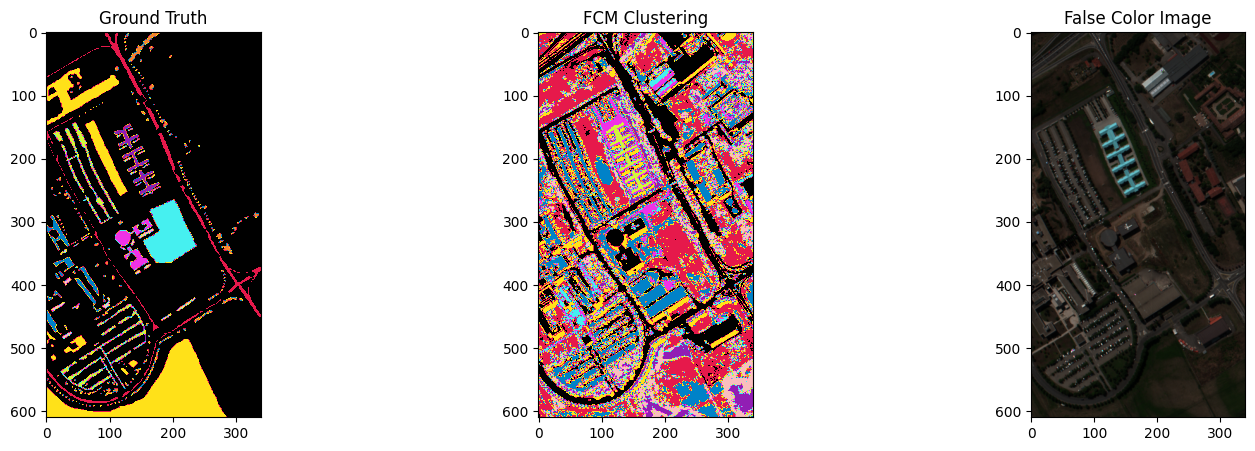

In [23]:
# print("Y", Y.shape)
# print("Z", Z.shape)
# print("Subcluster centers (M):", M.shape)
# print("Final cluster centers (V):", V.shape)
# 獲取最終群集標籤
labels = np.argmax(Y @ Z, axis=1)
print("Labels shape:", labels.shape)  # 輸出 labels 的形狀
clustered_img = labels.reshape(img.shape[:2])
print("Clustered image shape:", clustered_img.shape)  # 輸出重塑後的 clustered_img 的形狀

# 定義9種顏色
colors = [
    "#000000", "#e6194b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6",
    "#d2f53c", "#fabebe"
]
cmap = ListedColormap(colors)

plt.figure(figsize=(18, 5))

# Ground Truth
plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.imshow(gt, cmap=cmap)

# FCM Clustering Result
plt.subplot(1, 3, 2)
plt.title("FCM Clustering")
plt.imshow(clustered_img, cmap=cmap)

# False Color Image (使用波段 50, 27, 17)
false_color_img = img[:, :, [50, 27, 17]]

# 縮放假彩色圖像的值到0-255範圍
false_color_img = (false_color_img - false_color_img.min()) / (false_color_img.max() - false_color_img.min()) * 255
false_color_img = false_color_img.astype(np.uint8)

plt.subplot(1, 3, 3)
plt.title("False Color Image")
plt.imshow(false_color_img)
plt.show()

Accuracy: 29.61%
Overall Accuracy (OA): 29.61%
Average Accuracy (AA): 45.62%


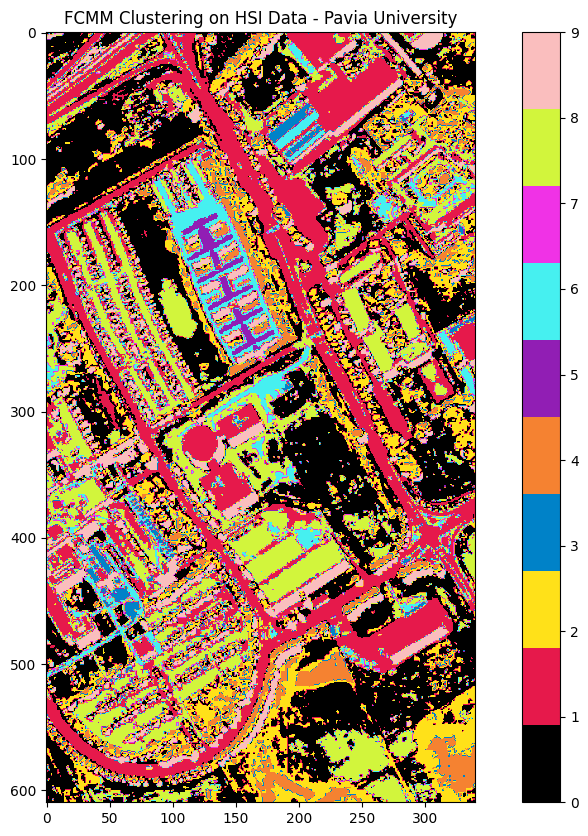

In [29]:
# 並且已經有 gt 加載和重塑為一維向量
gt_flat = gt.flatten()

# 計算混淆矩陣
cm = confusion_matrix(gt_flat, labels)
# print("Confusion Matrix:", cm)

# 使用匈牙利算法找到最佳標籤對應
row_ind, col_ind = linear_sum_assignment(-cm)  # 對成本矩陣取負值以求最大化

# 建立標籤映射，根據找到的對應關係重映射 FCMM 的結果
label_mapping = {col: row for col, row in zip(col_ind, row_ind)}
remapped_labels = np.array([label_mapping[label] for label in labels])

# 計算重映射後的準確率
accuracy = np.sum(remapped_labels == gt_flat) / gt_flat.size
print(f"Accuracy: {accuracy * 100:.2f}%")

cm_news = confusion_matrix(gt_flat, remapped_labels)

# 計算整體精確度 (Overall Accuracy, OA)
OA = np.trace(cm_news) / np.sum(cm_news)
print(f"Overall Accuracy (OA): {OA * 100:.2f}%")

# 計算平均精確度 (Average Accuracy, AA)
class_accuracies = np.diag(cm_news) / np.sum(cm_news, axis=1)
AA = np.mean(class_accuracies)
print(f"Average Accuracy (AA): {AA * 100:.2f}%")

# 可視化重映射後的分群結果
remapped_clustered_img = remapped_labels.reshape(img.shape[:2])

plt.figure(figsize=(12, 10))
plt.imshow(remapped_clustered_img, cmap=cmap)
plt.colorbar()
plt.title(f'FCMM Clustering on HSI Data - Pavia University')
plt.show()